In [103]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

In [104]:
# Set the Firefox driver path and Firefox executable file path
driver_path = './geckodriver' 
firefox_binary_path = 'C:/Program Files/Mozilla Firefox/firefox.exe'

In [105]:
def scrape_indeed(driver_path, firefox_binary_path, job_query, num_jobs_to_scrape):
    # Setting up Firefox
    options = webdriver.FirefoxOptions()
    binary = FirefoxBinary(firefox_binary_path)
    options.binary = binary

    # Setting the crawl URL
    url = f'https://www.indeed.com/jobs?q={job_query}&l='
    driver.get(url)
    time.sleep(5)  # Waiting for the page to load

    # Initialize the job information list
    job_data = []
    job_count = 0
    
    # Creating a WebDriver Instance
    driver = webdriver.Firefox(executable_path=driver_path, options=options)
    wait = WebDriverWait(driver, 10)

    while job_count < num_jobs_to_scrape:
        # Capture job cards
        job_cards = driver.find_elements(By.CSS_SELECTOR, '.job_seen_beacon')

        for job_card in job_cards:
            if job_count >= num_jobs_to_scrape:
                break
            try:
                # Extract job title, company name, location, and posting date
                title = job_card.find_element(By.CSS_SELECTOR, 'h2.jobTitle span').text
                company = job_card.find_element(By.CSS_SELECTOR, 'span[data-testid="company-name"]').text
                location = job_card.find_element(By.CSS_SELECTOR, 'div[data-testid="text-location"]').text
                date_posted = job_card.find_element(By.CSS_SELECTOR, 'span[data-testid="myJobsStateDate"]').text
                
                # Click on the job card to view the job description
                job_card.find_element(By.CSS_SELECTOR, 'a').click()  # Make sure to click on the link to view the detailed description
                time.sleep(3)  # Waiting for job descriptions to load

                # Wait for the job description to load
                job_description_element = wait.until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, '#jobDescriptionText'))
                )
                job_description = job_description_element.text

                # Extract salary information
                try:
                    salary = driver.find_element(By.CSS_SELECTOR, 'span.css-19j1a75').text
                except:
                    salary = 'N/A'
                
                # Extract job requirements and required skills
                requirements, skills = extract_requirements_and_skills(job_description)

                # Add the captured information to the list
                job_data.append({
                    'Title': title,
                    'Company': company,
                    'Location': location,
                    'Date Posted': date_posted,
                    'Description': job_description,
                    'Salary': salary,
                    'Requirements': requirements,
                    'Skills': skills
                })
                
                job_count += 1
                print(f"Collected job data: {title} at {company} in {location} ({job_count}/{num_jobs_to_scrape})")
                
                driver.back()
                time.sleep(3)  # Waiting to return to job list
            except Exception as e:
                print(f"Error: {e}")
                continue

        # Try to find and click the "Next Page" button
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, 'a[aria-label="Next"]')
            next_button.click()
            time.sleep(5)  # Waiting for a new page to load
        except Exception as e:
            print("No more pages to load.")
            break

    # Close the browser
    driver.quit()

    return job_data

In [106]:
def extract_requirements_and_skills(description):
    # Assume that the job requirements and required skills are contained between keywords
    requirements_keywords = ['Requirements', 'Qualifications', 'Must have']
    skills_keywords = ['Skills', 'Proficient in', 'Experience with']
    
    requirements = []
    skills = []

    lines = description.split('\n')
    capture_requirements = False
    capture_skills = False

    for line in lines:
        if any(keyword in line for keyword in requirements_keywords):
            capture_requirements = True
            capture_skills = False
        elif any(keyword in line for keyword in skills_keywords):
            capture_skills = True
            capture_requirements = False
        elif line.strip() == '':
            capture_requirements = False
            capture_skills = False
        
        if capture_requirements:
            requirements.append(line.strip())
        if capture_skills:
            skills.append(line.strip())

    return ' '.join(requirements), ' '.join(skills)


In [107]:
def main():
    num_jobs_to_scrape = 10  # Set the number of positions to crawl for each position type

    # Define a list of job types to crawl
    job_queries = [
        'data+scientist', 'software+engineer', 'project+manager', 'product+manager', 
        'business+analyst', 'web+developer', 'graphic+designer', 'network+engineer',
        'systems+administrator', 'database+administrator', 'quality+assurance', 
        'technical+support', 'data+analyst', 'security+analyst', 'data+engineer',
        'machine+learning+engineer', 'devops+engineer', 'cloud+architect', 'it+manager',
        'seo+specialist', 'digital+marketer', 'content+writer', 'sales+manager',
        'financial+analyst', 'accountant', 'hr+manager', 'marketing+manager',
        'customer+service+representative', 'operations+manager', 'logistics+coordinator',
        'procurement+manager', 'supply+chain+analyst', 'legal+assistant', 'paralegal',
        'nurse', 'medical+assistant', 'pharmacist', 'physical+therapist',
        'research+scientist', 'lab+technician', 'teacher', 'school+principal',
        'instructional+designer', 'education+consultant', 'library+assistant',
        'counselor', 'psychologist', 'social+worker', 'therapist',
        'engineer', 'mechanical+engineer', 'civil+engineer', 'electrical+engineer',
        'chemical+engineer', 'environmental+engineer', 'aerospace+engineer',
        'biomedical+engineer', 'architect', 'urban+planner',
        'construction+manager', 'electrician', 'plumber', 'carpenter',
        'welder', 'machinist', 'automotive+technician', 'hvac+technician',
        'chef', 'restaurant+manager', 'bartender', 'waiter',
        'event+planner', 'travel+agent', 'tour+guide', 'flight+attendant',
        'pilot', 'aircraft+mechanic', 'bus+driver', 'truck+driver',
        'mechanic', 'dispatcher', 'safety+manager', 'safety+specialist',
        'janitor', 'custodian', 'groundskeeper', 'landscaper',
        'security+guard', 'firefighter', 'police+officer', 'detective',
        'correctional+officer', 'emergency+medical+technician', 'paramedic',
        'fitness+trainer', 'personal+trainer', 'massage+therapist',
        'esthetician', 'hair+stylist', 'cosmetologist', 'barber'
    ]

    all_job_data = []

    # Traverse the list of job types and crawl the job information of each job type
    for job_query in job_queries:
        print(f"Scraping jobs for: {job_query.replace('+', ' ')}")
        job_data = scrape_indeed(driver_path, firefox_binary_path, job_query, num_jobs_to_scrape)
        all_job_data.extend(job_data)
    
    # Save all job data to a CSV file
    df = pd.DataFrame(all_job_data)
    df.to_csv('indeed_all_job_data.csv', index=False)

In [108]:
if __name__ == "__main__":
    main()

Scraping jobs for: data scientist
Collected job data: Data Scientist at Microsoft in Redmond, WA 98052 
(Overlake area) (1/10)
Collected job data: Early Career Data Scientist at WSP in Portland, ME 04101 
(Downtown area) (2/10)
Collected job data: Data Scientist at Amgen in Remote in Cambridge, MA (3/10)
Collected job data: Data Scientist at Booz Allen in Arlington, VA (4/10)
Collected job data: Data Scientist I at Warner Bros. Discovery in Bellevue, WA 98004 
(Downtown area) (5/10)
Collected job data: Data Scientist at Microsoft in Atlanta, GA (6/10)
Collected job data: Data Scientist at Bayer in Chesterfield, MO (7/10)
Collected job data: Data Scientist at Flexday in United States (8/10)
Collected job data: Data Scientist at Comscore in Oregon (9/10)
Collected job data: Data Scientist at WALGREENS in Deerfield, IL 60015 (10/10)
No more pages to load.
Scraping jobs for: software engineer
Collected job data: Entry Level Software Engineer at Leidos in Alabama (1/10)
Collected job data: 

Collected job data: SYSTEMS ADMINISTRATOR II at City of Rockwall in Rockwall, TX 75087 (6/10)
Collected job data: Systems Administrator III at Georgia Gwinnett College in Lawrenceville, GA 30043 (7/10)
Collected job data: Systems Administrator at IGT in Providence, RI 02903 
(Downtown area) (8/10)
Collected job data: Systems Administrator/Programmer at Florida State University in Tallahassee, FL (9/10)
Collected job data: IT - Site Administrator at Woodgrain in Davenport, FL 33897 (10/10)
No more pages to load.
Scraping jobs for: database administrator
Collected job data: Database Administrator at Global Financial Data, Inc in Hybrid work in Irvine, CA 92618 (1/10)
Collected job data: SQL Database Administrator (non-remote) at Goodwill Industries Southern Rivers in Columbus, GA 31906 (2/10)
Collected job data: Junior Database Administrator at SDI Presence in Chicago, IL 60666 (3/10)
Collected job data: Junior Database Administrator at Cape Fear Public Utility Authority in Wilmington, N

Collected job data: Junior DevOps Engineer at Camgian in Starkville, MS 39759 (3/10)
Collected job data: Infrastructure and DevOps Engineer at INTEL in Hillsboro, OR (4/10)
Collected job data: Junior AWS DevOps Engineer - Remote at Perficient, Inc in Remote in United States (5/10)
Collected job data: DevOps Engineer III (Remote) at CrowdStrike in Remote (6/10)
Collected job data: Cloud DevOps Engineer at Dematic Corp. in Michigan (7/10)
Collected job data: ADAS DevOps Java Engineer at Ford Motor Company in Hybrid work in United States (8/10)
Collected job data: DevOps Engineer at AllStars-IT in Georgia (9/10)
Collected job data: Junior DevOps Engineer at Index Analytics Llc in Remote in Windsor Mill, MD 21244 (10/10)
No more pages to load.
Scraping jobs for: cloud architect
Collected job data: Cloud Data Architect at Ford Motor Company in Hybrid work in Dearborn, MI 48124 (1/10)
Collected job data: Cloud Architect - Remote at GXO Logistics in Remote in Florida (2/10)
Collected job data

Collected job data: Staff Accountant at Woodgrain in Lenoir, NC 28645 (6/10)
Collected job data: Accountant at Caterpillar in Hybrid work in Nashville, TN (7/10)
Collected job data: Accountant 1 at University of North Carolina at Chapel Hill in Chapel Hill, NC 27599 (8/10)
Collected job data: Accountant - Foundation at Providence in Santa Monica, CA 90404 (9/10)
Collected job data: Accountant II, Accounts Payable & Intercompany (Full-time Remote) at BAE Systems in Remote in Nashua, NH 03060 (10/10)
No more pages to load.
Scraping jobs for: hr manager
Collected job data: HR Generalist at Under Armour in Hybrid work in Baltimore, MD 21230 (1/10)
Collected job data: HR Team Lead at University of North Carolina at Chapel Hill in Chapel Hill, NC 27599 (2/10)
Collected job data: HR Manager at White Oak Manor York in York, SC 29745 (3/10)
Collected job data: Employee Benefits Specialist - Houston, TX at Hewlett Packard Enterprise in Hybrid work in Spring, TX 77389 (4/10)
Collected job data: H

Collected job data: Legal Assistant 1 Western Region at Commonwealth of PA in Remote in Allegheny County, PA (2/10)
Collected job data: Legal Assistant II at Georgia State University in Atlanta, GA 30303 
(Downtown area) (3/10)
Collected job data: Legal Clerical Assistant - Lake Mary, Florida at The Hartford in Lake Mary, FL (4/10)
Collected job data: Legal Assistant at Seminole County, FL in Sanford, FL 32771 (5/10)
Collected job data: LEGAL ASSISTANT I at State of Colorado Job Opportunities in Colorado Springs, CO (6/10)
Collected job data: Legal Administrative Assistant at City and County of Denver in Denver, CO 80202 (7/10)
Collected job data: Legal Services Assistant at Loudoun County Government in Leesburg, VA (8/10)
Collected job data: Legal Assistant at Ambu in Hybrid work in Columbia, MD (9/10)
Collected job data: Legal and Communications Assistant at Harvard University in Cambridge, MA (10/10)
No more pages to load.
Scraping jobs for: paralegal
Collected job data: Paralegal I

Collected job data: Chemistry Lab Technician at Coppin State University in Baltimore, MD 21216 
(Mondawin area) (8/10)
Collected job data: Genomics Technician - Molecular Lab - Days at The University of Chicago Medicine in Chicago, IL 60637 
(Hyde Park area) (9/10)
Collected job data: Lab Technician, Yogurt at Danone in Louisville, CO (10/10)
No more pages to load.
Scraping jobs for: teacher
Collected job data: Kaneohe Elementary - Grade 6 Teacher (2024-02698) at Hawaiʻi State Department of Education in Kaneohe, HI 96744 (1/10)
Collected job data: Manoa Elementary - Kindergarten Teacher (2024-02569) at Hawaiʻi State Department of Education in Honolulu, HI 96822 
(Manoa area) (2/10)
Collected job data: Teacher-4th Grade at Garfield Re-2 School District in Rifle, CO 81650 (3/10)
Collected job data: Virtual School Teacher K-5 at Lake County Illinois in Vernon Hills, IL (4/10)
Collected job data: Elementary Classroom Teacher (Grades 1-5) (Anticipated for 24/25 School Year) at Norwood Publi

Collected job data: Clinical Psychologist - Mother and Child Integrated Mental Health Program - Grant Funded at NewYork-Presbyterian Hospital in Manhattan, NY (5/10)
Collected job data: Clinical Psychologist at US Federal Bureau of Investigation in Washington, DC 20535 
(Penn Quarter area) (6/10)
Collected job data: Psychological Testing Psychologist at Complete health primary care in Lincoln, RI 02865 (7/10)
Collected job data: Psychologist Trainee - Psychiatry Clinic at UAB Medicine - UA Health Services Foundation... in Birmingham, AL (8/10)
Collected job data: Psychologist Assistant at Peter M Bradlee, PhD in Fairfield, CA 94534 (9/10)
Collected job data: Clinical Psychologist at Senior Care Therapy in Monticello, NY (10/10)
No more pages to load.
Scraping jobs for: social worker
Collected job data: Social Worker II at Cumberland County, NC in Remote in Fayetteville, NC (1/10)
Collected job data: Social Worker I - Wraparound - Health and Social Services at Gwinnett County Public Sch

Collected job data: Chemical Engineer at WA River Protection Solutions in Richland, WA (6/10)
Collected job data: Co-Op Chemical Engineer at Ashland in Fiskeville, RI (7/10)
Collected job data: Chemical Engineer at WA River Protection Solutions in Richland, WA (8/10)
Collected job data: Chemical Engineer I at Honeywell in Baton Rouge, LA 70821 (9/10)
Collected job data: Early Career Environmental Engineer at WSP in Atlanta, GA (10/10)
No more pages to load.
Scraping jobs for: environmental engineer
Collected job data: Environmental Engineer at International Paper in Pine Hill, AL 36769 (1/10)
Collected job data: Early Career Environmental Engineer at WSP in Atlanta, GA (2/10)
Collected job data: Environmental Engineer at Honda in Lincoln, AL 35096 (3/10)
Collected job data: Early Career Environmental Engineer at EA Engineering Science and Technology in Warwick, RI (4/10)
Collected job data: Environmental Engineer I at Jacobs Engineering Group Inc. in Research Triangle Park, NC 27709 (5

No more pages to load.
Scraping jobs for: plumber
Collected job data: Plumber at Jackson & Sons in Dudley, NC 28333 (1/10)
Collected job data: Plumber/Steamfitter I at University Hospital, Newark NJ in Newark, NJ 07103 
(University Heights area) (2/10)
Collected job data: Journeyworker Plumber at University of Utah Health in Salt Lake City, UT 84108 
(East Bench area) (3/10)
Collected job data: Plumber at State of Montana in Warm Springs, MT 59756 (4/10)
Collected job data: Plumber A - Evenings - Weekends at NewYork-Presbyterian Hospital in New York, NY 10032 
(Washington Heights area) (5/10)
Collected job data: Plumber at Los Angeles Community College District in Los Angeles, CA 90015 
(Historic South-Central area) (6/10)
Collected job data: Plumber - Plant Services - Full Time at The Guthrie Clinic in Binghamton, NY 13905 (7/10)
Collected job data: Plumber (Part-Time) at SeaWorld Orlando in Orlando, FL 32821 (8/10)
Collected job data: Plumber at Campbell & Company in Yakima, WA 98901

Collected job data: Restaurant General Manager at Kohler in Kohler, WI 53044 (10/10)
No more pages to load.
Scraping jobs for: bartender
Collected job data: Bartender - Dollywood's HeartSong Lodge & Resort - Full Time Year Round at Dollywood Parks & Resorts in Pigeon Forge, TN (1/10)
Collected job data: BARTENDER – $20/HOUR + INCENTIVE at Miraval Austin Resort and Spa in Austin, TX 78726 (2/10)
Collected job data: Bartender/Lounge Server - Glacier National Park at Xanterra Travel Collection in Columbia Falls, MT 59912 (3/10)
Collected job data: Bartender at Glenmoor Country Club in Cherry Hills Village, CO 80113 (4/10)
Collected job data: BARTENDER - BEVERAGE - ON CALL at Hyatt Regency Waikiki Beach Resort and Spa in Honolulu, HI 96815 
(Waikiki area) (5/10)
Collected job data: Taproom Team Member at Von Ebert Brewing in Beaverton, OR (6/10)
Collected job data: Bartender - 8366 at Yard House in Austin, TX 78758 
(The Domain area) (7/10)
Collected job data: Bartender West - On-Call at H

Collected job data: Sheet Metal Mechanic (Aircraft) at U.S. Army Reserve Command in Joint Base Lewis McChord, WA (5/10)
Collected job data: Aircraft Mechanic I (MV-22 Flight Line) at Kay & Associates, Inc. in Yuma, AZ 85365 (6/10)
Collected job data: A&P Mechanic ( Aircraft ) at CVS Health in Warwick, RI (7/10)
Collected job data: Supervisor - Aircraft Maintenance at United Airlines in Hawaii (8/10)
Collected job data: Aircraft Mechanic at Bombardier in Tucson, AZ 85706 (9/10)
Collected job data: AIRCRAFT MECHANIC at US Army National Guard Units in Joint Base Lewis McChord, WA (10/10)
No more pages to load.
Scraping jobs for: bus driver
Collected job data: BUS DRIVER (Howell, NJ) at NJ Transit in Township of Howell, NJ (1/10)
Collected job data: Bus Driver Foreman at Prince George's County Public Schools in Upper Marlboro, MD 20772 (2/10)
Collected job data: Certified Bus Driver at Silsbee Independent School District in United States (3/10)
Collected job data: Paratransit Operator (Van

Collected job data: CUSTODIAN I at University of Michigan in Ann Arbor, MI 48109 (5/10)
Collected job data: Custodian - CORONADO HS at Clark County School District in Henderson, NV 89052 
(Westgate area) (6/10)
Collected job data: Custodian at Pasco County Schools in Wesley Chapel, FL 33545 (7/10)
Collected job data: School Custodian III - Fern Elementary at Hawaiʻi State Department of Education in Honolulu, HI 96819 (8/10)
Collected job data: Custodian at Mayo Clinic in Rochester, MN 55905 
(Downtown area) (9/10)
Collected job data: Custodian B at Harvard University in Cambridge, MA (10/10)
No more pages to load.
Scraping jobs for: groundskeeper
Collected job data: Groundskeeper at The University of Mississippi in University, MS 38677 (1/10)
Collected job data: GROUNDSKEEPER at Department of State Hospitals in San Bernardino County, CA (2/10)
Collected job data: Groundskeeper - Grounds Maintenance at Gwinnett County Public Schools in Gwinnett County, GA (3/10)
Collected job data: Grou

Collected job data: Correctional Officer at City of Kansas City in Kansas City, MO 64106 
(CBD Downtown area) (8/10)
Collected job data: Correctional Officer, POST at State of Utah in Utah (9/10)
Collected job data: Correctional Officer - Adult Corrections Facility at Hennepin County in Plymouth, MN 55447 (10/10)
No more pages to load.
Scraping jobs for: emergency medical technician
Collected job data: Emergency Medical Technician / EMT Trainee at Atlantic Health System in New Jersey (1/10)
Collected job data: Emergency Medical Technician at SeaWorld Orlando in Orlando, FL 32821 (2/10)
Collected job data: Emergency Medical Technician at Allied Universal® Risk Advisory and Consulting... in New York, NY 10005 
(Financial District area) (3/10)
Collected job data: Emergency Medical Technician (EMT)-Main Hospital Emergency Department at University of Utah Health in Salt Lake City, UT 84112 
(East Bench area) (4/10)
Collected job data: Emergency Medical Technician at Northern Light Health in

Collected job data: Licensed Esthetician or Cosmetologist at EWC Staffing LLC in Gonzales, LA 70737 (1/10)
Collected job data: Hair Stylist at BAY CLIPS INC in Newport News, VA 23608 (2/10)
Collected job data: Cosmetologist (Full-Time / Part Time) at Studio A Salon Spa in Osceola, WI 54020 (3/10)
Collected job data: Teacher, Cosmetology at Northeast Metro 916 Intermediate School District in White Bear Lake, MN 55110 (4/10)
Collected job data: Cosmetology Specialist - Full Time - Walt Disney World at Walt Disney World Resort in Orlando, FL 32830 (5/10)
Collected job data: COSMETOLOGIST - PART TIME at Hyatt Regency Tamaya Resort and Spa in Bernalillo, NM (6/10)
Collected job data: Cosmetologist at GBMC Healthcare in Towson, MD (7/10)
Collected job data: Cosmetologist at Riverside Casino and Golf Resort in Riverside, IA 52327 (8/10)
Collected job data: Cosmetologist, Kohler Waters Spa at Kohler in Kohler, WI 53044 (9/10)
Collected job data: Adjunct Instructor, Cosmetology, 12 month at The

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file and specify the encoding as 'ISO-8859-1'
data = pd.read_csv('indeed_all_job_data.csv', encoding='ISO-8859-1')

# Make sure have downloaded the necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Cleanup Function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Participle
    words = text.split()
    # Stop word removal and lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Convert all columns to string type and handle missing values
data['Description'] = data['Description'].astype(str).fillna('')

# Applying cleanup functions
data['cleaned_description'] = data['Description'].apply(clean_text)

# View the cleaned data
print(data[['Title', 'cleaned_description']].head(11))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                            Title  \
0                  Data Scientist   
1     Early Career Data Scientist   
2                  Data Scientist   
3                Data Scientist I   
4                  Data Scientist   
5                  Data Scientist   
6                  Data Scientist   
7                  Data Scientist   
8                  Data Scientist   
9                Data Scientist21   
10  Entry Level Software Engineer   

                                  cleaned_description  
0   azure core organization responsible creating f...  
1   business global leader environmental consultin...  
2   data scientist opportunity data scientist your...  
3   welcome warner bros discovery stuff dream made...  
4   interested startup like environment passionate...  
5   bayer visionary driven solve world toughest ch...  
6   location u vancouver canada role seeking highl...  
7   job function data scientist position part tele...  
8   job summary applies advanced data analysis too.

In [4]:
# Standardized occupational titles
job_queries = [
    'data+scientist', 'software+engineer', 'project+manager', 'product+manager', 
    'business+analyst', 'web+developer', 'graphic+designer', 'network+engineer',
    'systems+administrator', 'database+administrator', 'quality+assurance', 
    'technical+support', 'data+analyst', 'security+analyst', 'data+engineer',
    'machine+learning+engineer', 'devops+engineer', 'cloud+architect', 'it+manager',
    'seo+specialist', 'digital+marketer', 'content+writer', 'sales+manager',
    'financial+analyst', 'accountant', 'hr+manager', 'marketing+manager',
    'customer+service+representative', 'operations+manager', 'logistics+coordinator',
    'procurement+manager', 'supply+chain+analyst', 'legal+assistant', 'paralegal',
    'nurse', 'medical+assistant', 'pharmacist', 'physical+therapist',
    'research+scientist', 'lab+technician', 'teacher', 'school+principal',
    'instructional+designer', 'education+consultant', 'library+assistant',
    'counselor', 'psychologist', 'social+worker', 'therapist',
    'engineer', 'mechanical+engineer', 'civil+engineer', 'electrical+engineer',
    'chemical+engineer', 'environmental+engineer', 'aerospace+engineer',
    'biomedical+engineer', 'architect', 'urban+planner',
    'construction+manager', 'electrician', 'plumber', 'carpenter',
    'welder', 'machinist', 'automotive+technician', 'hvac+technician',
    'chef', 'restaurant+manager', 'bartender', 'waiter',
    'event+planner', 'travel+agent', 'tour+guide', 'flight+attendant',
    'pilot', 'aircraft+mechanic', 'bus+driver', 'truck+driver',
    'mechanic', 'dispatcher', 'safety+manager', 'safety+specialist',
    'janitor', 'custodian', 'groundskeeper', 'landscaper',
    'security+guard', 'firefighter', 'police+officer', 'detective',
    'correctional+officer', 'emergency+medical+technician', 'paramedic',
    'fitness+trainer', 'personal+trainer', 'massage+therapist',
    'esthetician', 'hair+stylist', 'cosmetologist', 'barber'
]

# 10 for each profession, standardize the profession query list
standardized_titles = []
for job_query in job_queries:
    standardized_title = job_query.replace('+', ' ')
    standardized_titles.extend([standardized_title] * 10)

# Add standardized occupation titles to the dataset
data['standardized_title'] = standardized_titles

# View the cleaned data
print(data[['Title', 'cleaned_description', 'standardized_title']].head(20))


                                                Title  \
0                                      Data Scientist   
1                         Early Career Data Scientist   
2                                      Data Scientist   
3                                    Data Scientist I   
4                                      Data Scientist   
5                                      Data Scientist   
6                                      Data Scientist   
7                                      Data Scientist   
8                                      Data Scientist   
9                                    Data Scientist21   
10                      Entry Level Software Engineer   
11                             Software Engineer AMTS   
12  Software Engineer - Early in Career (Backend/F...   
13                      Entry Level Software Engineer   
14              Software Engineer - Front End (React)   
15           Software Triage Engineer - tvOS Platform   
16                             

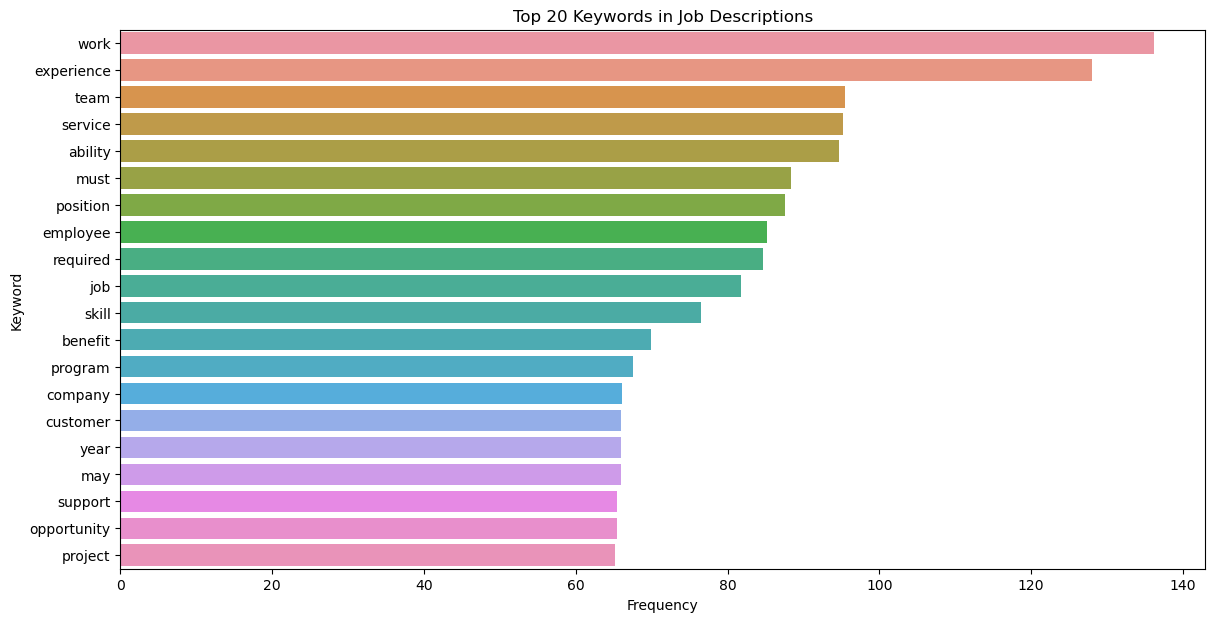

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract keywords using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_description'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sum = tfidf_matrix.sum(axis=0)
tfidf_freq = [(word, tfidf_sum[0, idx]) for word, idx in zip(tfidf_feature_names, range(tfidf_sum.shape[1]))]
tfidf_freq = sorted(tfidf_freq, key=lambda x: x[1], reverse=True)

# Convert keywords and frequencies into DataFrame
tfidf_df = pd.DataFrame(tfidf_freq, columns=['Keyword', 'Frequency'])

# Visualize the top 20 keywords
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Keyword', data=tfidf_df.head(20))
plt.title('Top 20 Keywords in Job Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()


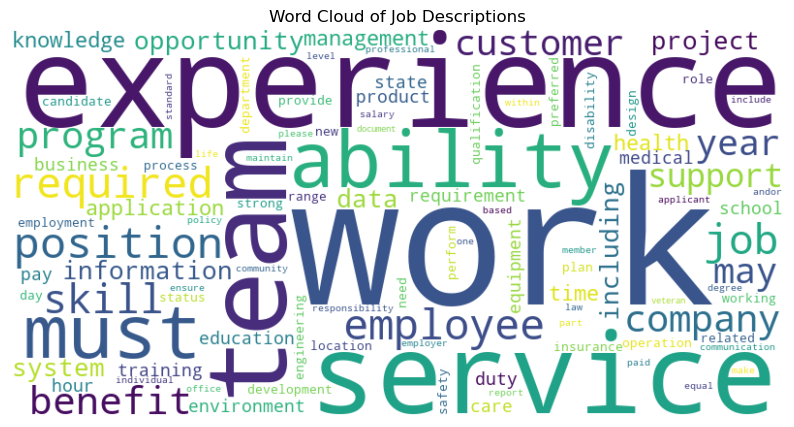

In [7]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(tfidf_freq))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Descriptions')
plt.show()


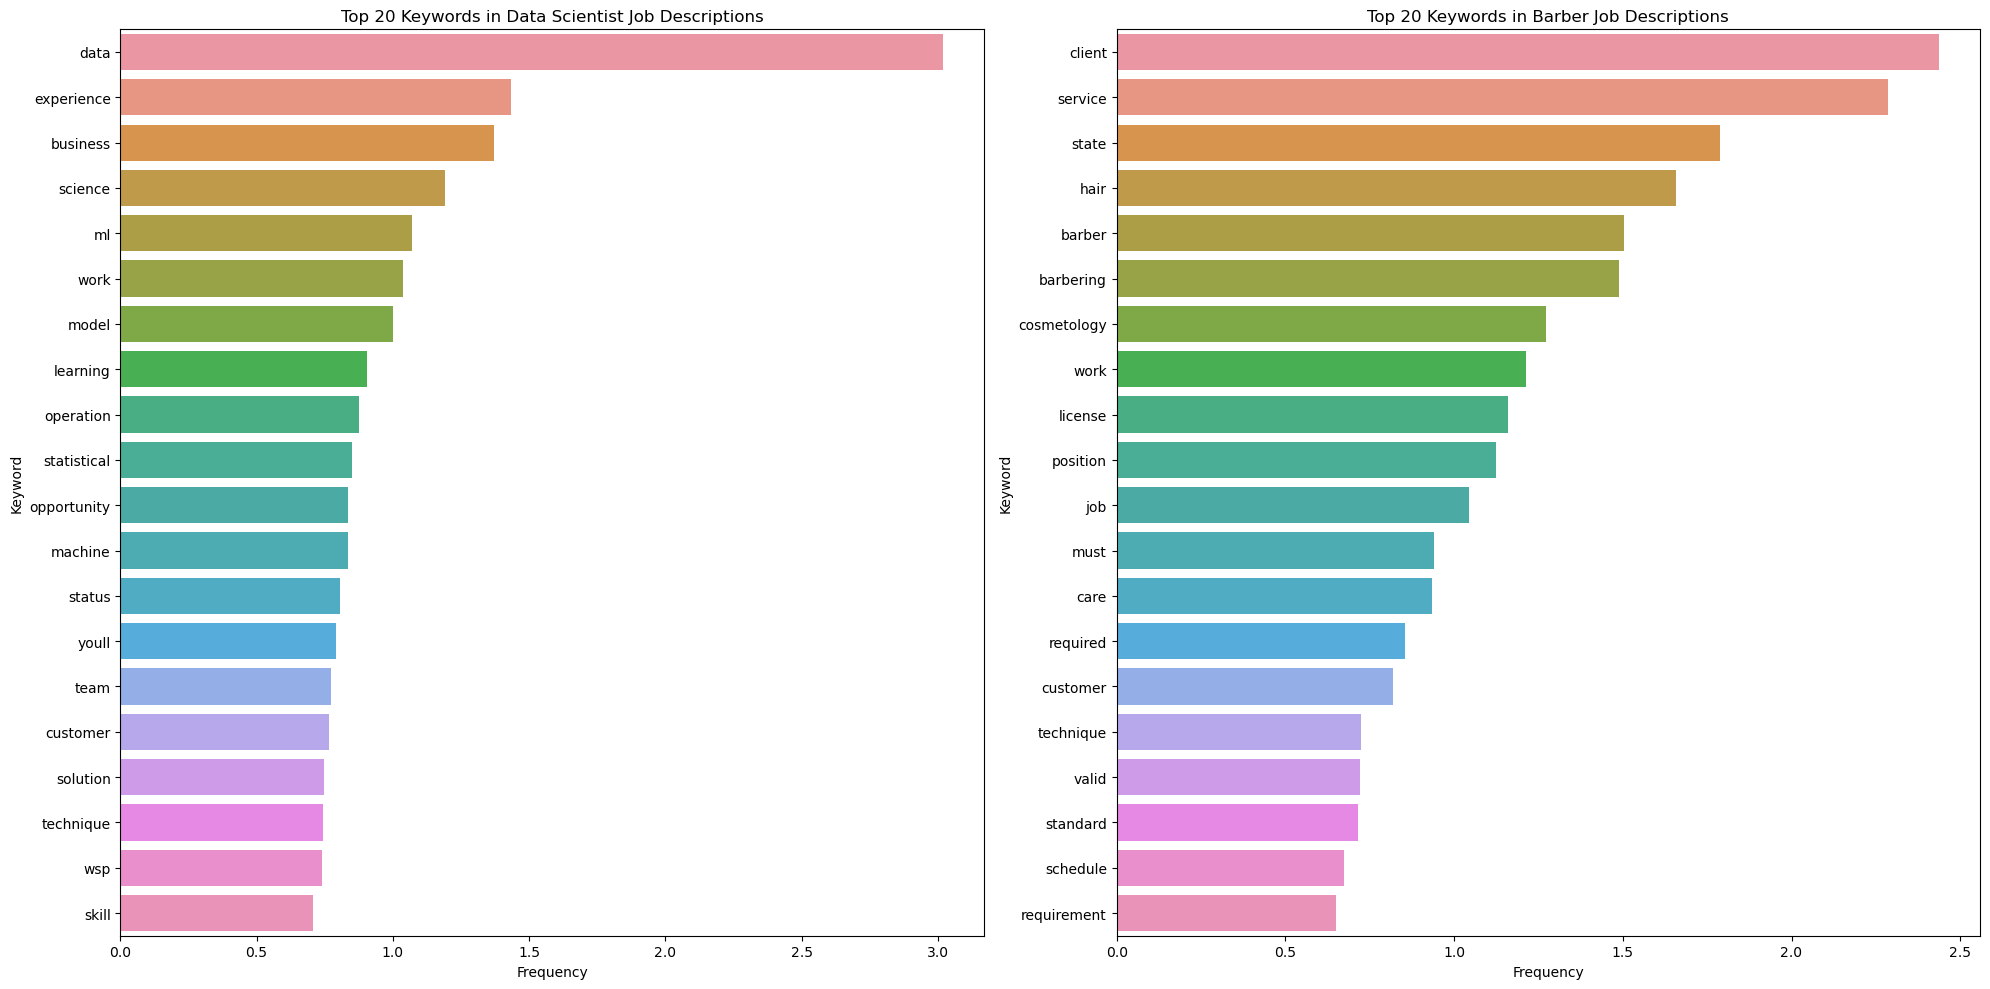

In [8]:
compare_jobs = ['data scientist', 'barber']

# Calculate and visualize job keywords
def analyze_job_keywords(job_title):
    job_data = data[data['standardized_title'] == job_title]
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    job_tfidf_matrix = tfidf_vectorizer.fit_transform(job_data['cleaned_description'])
    job_tfidf_sum = job_tfidf_matrix.sum(axis=0)
    job_tfidf_freq = [(word, job_tfidf_sum[0, idx]) for word, idx in zip(tfidf_vectorizer.get_feature_names_out(), range(job_tfidf_sum.shape[1]))]
    job_tfidf_freq = sorted(job_tfidf_freq, key=lambda x: x[1], reverse=True)
    job_tfidf_df = pd.DataFrame(job_tfidf_freq, columns=['Keyword', 'Frequency'])
    return job_tfidf_df

# Calculate keywords for two positions separately
data_scientist_keywords = analyze_job_keywords('data scientist')
barber_keywords = analyze_job_keywords('barber')

# Visualize the top 20 keywords comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x='Frequency', y='Keyword', data=data_scientist_keywords.head(20), ax=axes[0])
axes[0].set_title('Top 20 Keywords in Data Scientist Job Descriptions')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Keyword')

sns.barplot(x='Frequency', y='Keyword', data=barber_keywords.head(20), ax=axes[1])
axes[1].set_title('Top 20 Keywords in Barber Job Descriptions')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Keyword')

plt.tight_layout()
plt.show()

Accuracy: 70.79%
                                 precision    recall  f1-score   support

                     accountant       0.50      0.50      0.50         2
             aerospace engineer       0.50      0.50      0.50         2
              aircraft mechanic       1.00      0.50      0.67         2
                      architect       0.67      1.00      0.80         2
          automotive technician       1.00      1.00      1.00         2
                         barber       1.00      1.00      1.00         2
                      bartender       1.00      1.00      1.00         2
            biomedical engineer       0.33      0.50      0.40         2
                     bus driver       1.00      0.50      0.67         2
               business analyst       1.00      0.50      0.67         2
                      carpenter       1.00      1.00      1.00         2
                           chef       0.67      1.00      0.80         2
              chemical engineer  

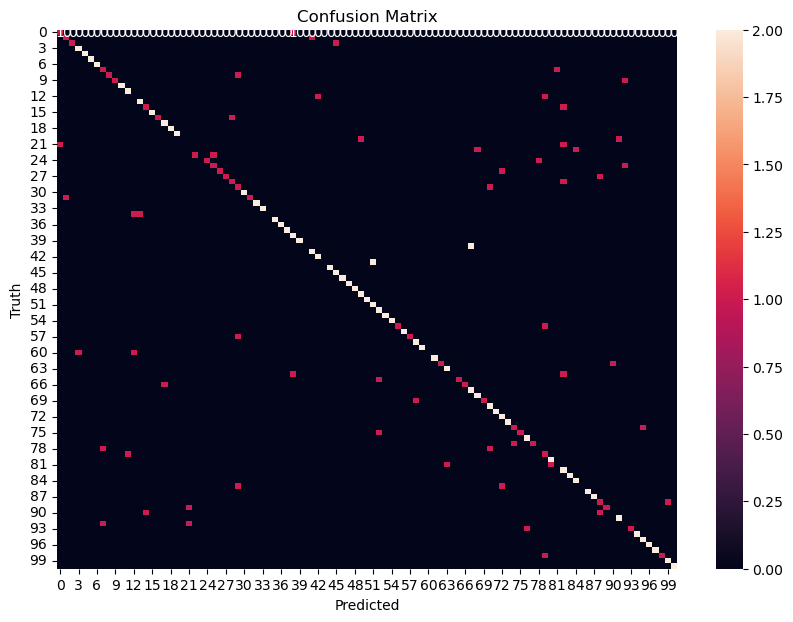

The most suitable job for the skill set 'machine learning python data analysis' is: restaurant manager


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['cleaned_description'])

# Creating a label mapping
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['standardized_title'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Prediction Function
def predict_job(skill_set):
    cleaned_skill_set = clean_text(skill_set)
    skill_vector = tfidf_vectorizer.transform([cleaned_skill_set])
    prediction = clf.predict(skill_vector)
    predicted_index = prediction[0]
    return label_encoder.inverse_transform([predicted_index])[0]

# Sample Skill Sets
skill_set = "machine learning python data analysis"
predicted_job = predict_job(skill_set)
print(f"The most suitable job for the skill set '{skill_set}' is: {predicted_job}")

C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:3.95386	validation_0-merror:0.85149
[1]	validation_0-mlogloss:3.41858	validation_0-merror:0.60891
[2]	validation_0-mlogloss:2.97828	validation_0-merror:0.47030
[3]	validation_0-mlogloss:2.65657	validation_0-merror:0.41584
[4]	validation_0-mlogloss:2.39636	validation_0-merror:0.39109
[5]	validation_0-mlogloss:2.23091	validation_0-merror:0.39109
[6]	validation_0-mlogloss:2.09366	validation_0-merror:0.39604
[7]	validation_0-mlogloss:1.98283	validation_0-merror:0.38614
[8]	validation_0-mlogloss:1.89927	validation_0-merror:0.37129
[9]	validation_0-mlogloss:1.83299	validation_0-merror:0.36139
[10]	validation_0-mlogloss:1.78713	validation_0-merror:0.36139
[11]	validation_0-mlogloss:1.74266	validation_0-merror:0.35149
[12]	validation_0-mlogloss:1.70270	validation_0-merror:0.35149
[13]	validation_0-mlogloss:1.67684	validation_0-merror:0.34158
[14]	validation_0-mlogloss:1.64131	validation_0-merror:0.34653
[15]	validation_0-mlogloss:1.62648	validation_0-merror:0.35149
[1

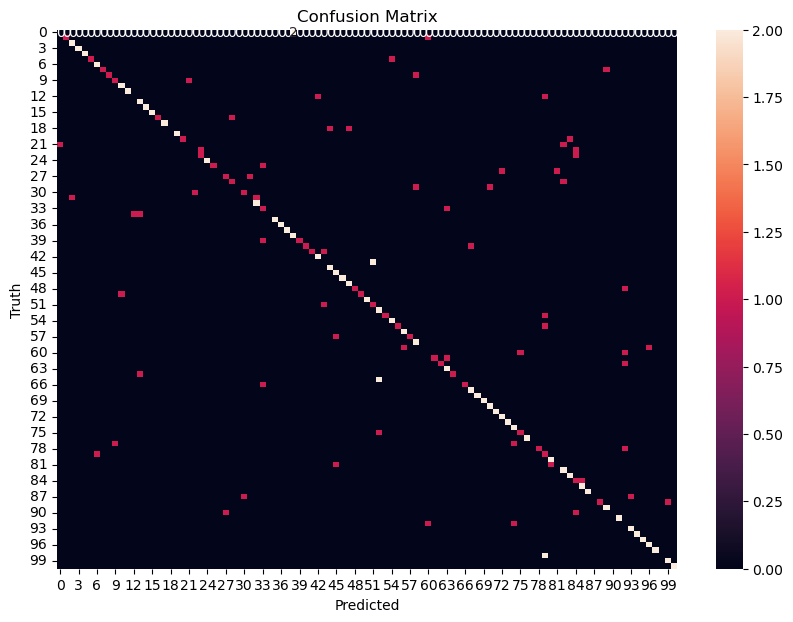

The most suitable job for the skill set 'machine learning python data analysis' is: data engineer


In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['cleaned_description'])

# Creating a label mapping
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['standardized_title'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing the XGBoost Model
clf = xgb.XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_), random_state=42)

# Training the model
clf.fit(X_train, y_train, eval_metric=["mlogloss", "merror"], eval_set=[(X_test, y_test)], verbose=True)

# predict
y_pred = clf.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Prediction Function
def predict_job(skill_set):
    cleaned_skill_set = clean_text(skill_set)
    skill_vector = tfidf_vectorizer.transform([cleaned_skill_set])
    prediction = clf.predict(skill_vector)
    predicted_index = prediction[0]
    return label_encoder.inverse_transform([predicted_index])[0]

# Sample Skill Sets
skill_set = "machine learning python data analysis"
predicted_job = predict_job(skill_set)
print(f"The most suitable job for the skill set '{skill_set}' is: {predicted_job}")


Accuracy: 65.35%
                                 precision    recall  f1-score   support

                     accountant       0.50      0.50      0.50         2
             aerospace engineer       0.00      0.00      0.00         2
              aircraft mechanic       1.00      0.50      0.67         2
                      architect       1.00      0.50      0.67         2
          automotive technician       1.00      1.00      1.00         2
                         barber       1.00      0.50      0.67         2
                      bartender       1.00      0.50      0.67         2
            biomedical engineer       0.00      0.00      0.00         2
                     bus driver       1.00      0.50      0.67         2
               business analyst       0.33      0.50      0.40         2
                      carpenter       1.00      0.50      0.67         2
                           chef       1.00      0.50      0.67         2
              chemical engineer  

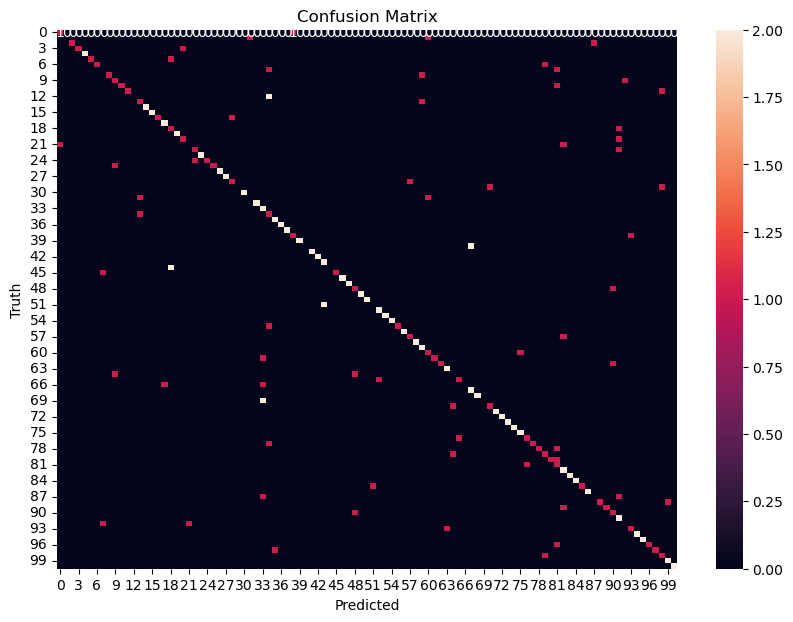

The most suitable job for the skill set 'machine learning python data analysis' is: machine learning engineer


In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Initialize the SVM model
svm_model = SVC(kernel='linear', probability=True)

# Training the model
svm_model.fit(X_train, y_train)

# predict
y_pred = svm_model.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Prediction Function
def predict_job(skill_set):
    cleaned_skill_set = clean_text(skill_set)
    skill_vector = tfidf_vectorizer.transform([cleaned_skill_set])
    prediction = svm_model.predict(skill_vector)
    predicted_index = prediction[0]
    return label_encoder.inverse_transform([predicted_index])[0]

# Sample Skill Sets
skill_set = "machine learning python data analysis"
predicted_job = predict_job(skill_set)
print(f"The most suitable job for the skill set '{skill_set}' is: {predicted_job}")


Epoch 1/100
21/21 [==============================] - 1s 30ms/step - loss: 5.4072 - accuracy: 0.0062 - val_loss: 4.6034 - val_accuracy: 0.0185
Epoch 2/100
21/21 [==============================] - 1s 24ms/step - loss: 4.7422 - accuracy: 0.0310 - val_loss: 4.5972 - val_accuracy: 0.0247
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 4.6467 - accuracy: 0.0325 - val_loss: 4.5938 - val_accuracy: 0.0494
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 4.4332 - accuracy: 0.0279 - val_loss: 4.5620 - val_accuracy: 0.0617
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 4.3585 - accuracy: 0.0604 - val_loss: 4.5589 - val_accuracy: 0.0617
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - loss: 4.2969 - accuracy: 0.0681 - val_loss: 4.5385 - val_accuracy: 0.0679
Epoch 7/100
21/21 [==============================] - 0s 23ms/step - loss: 4.3207 - accuracy: 0.0712 - val_loss: 4.5132 - val_accuracy: 0.0926
Epoch 

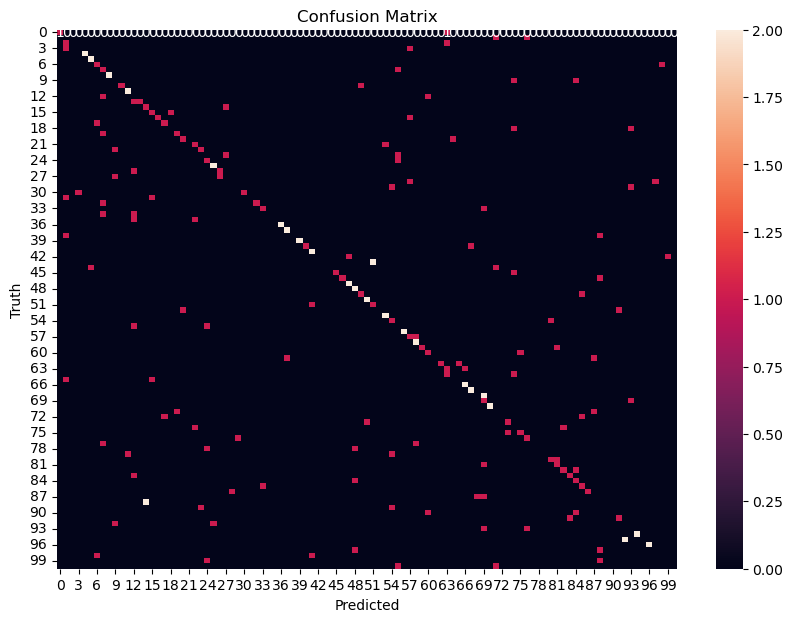

1/1 [==============================] - 0s 18ms/step
The most suitable job for the skill set 'machine learning python data analysis' is: machine learning engineer


In [13]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['cleaned_description'])

# Create label mapping
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['standardized_title'])

# Convert labels to one-hot encoding
y = to_categorical(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize neural network model
ann = tf.keras.models.Sequential()

# Add input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape=(X_train.shape[1],)))
ann.add(tf.keras.layers.Dropout(0.5))

# Add second hidden layer
ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))

# Add third hidden layer
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))

# Add output layer
ann.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

# Compile model
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred = ann.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate model
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Prediction function
def predict_job(skill_set):
    cleaned_skill_set = clean_text(skill_set)
    skill_vector = tfidf_vectorizer.transform([cleaned_skill_set]).toarray()
    skill_vector = sc.transform(skill_vector)
    prediction = ann.predict(skill_vector)
    predicted_index = np.argmax(prediction, axis=1)[0]
    return label_encoder.inverse_transform([predicted_index])[0]

# Sample skill set
skill_set = "machine learning python data analysis"
predicted_job = predict_job(skill_set)
print(f"The most suitable job for the skill set '{skill_set}' is: {predicted_job}")


Epoch 1/200
21/21 [==============================] - 1s 9ms/step - loss: 7.2935 - accuracy: 0.0108 - val_loss: 4.6299 - val_accuracy: 0.0123
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 4.9044 - accuracy: 0.0139 - val_loss: 4.6212 - val_accuracy: 0.0123
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 4.7373 - accuracy: 0.0046 - val_loss: 4.6220 - val_accuracy: 0.0062
Epoch 4/200
21/21 [==============================] - 0s 2ms/step - loss: 4.7108 - accuracy: 0.0124 - val_loss: 4.6247 - val_accuracy: 0.0062
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 4.6358 - accuracy: 0.0139 - val_loss: 4.6253 - val_accuracy: 0.0000e+00
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 4.6680 - accuracy: 0.0108 - val_loss: 4.6248 - val_accuracy: 0.0000e+00
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 4.6644 - accuracy: 0.0108 - val_loss: 4.6272 - val_accuracy: 0.0062
Epoch

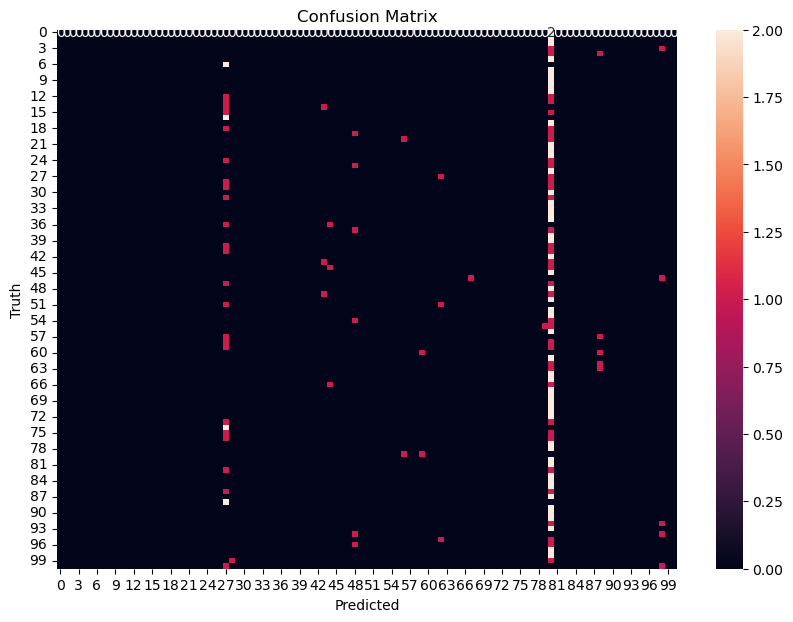

1/1 [==============================] - 0s 17ms/step
The most suitable job for the skill set 'machine learning python data analysis' is: mechanic


In [15]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Train the Word2Vec model
sentences = data['cleaned_description'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert each job description to a vector
def vectorize_text(text, model, vector_size):
    words = [word for word in text if word in model.wv.index_to_key]
    if len(words) == 0:
        return np.zeros(vector_size)
    word_vectors = model.wv[words]
    return np.mean(word_vectors, axis=0)

data['vectorized_description'] = data['cleaned_description'].apply(lambda x: vectorize_text(x, word2vec_model, 100))

# Build the feature matrix
X = np.stack(data['vectorized_description'].values)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['standardized_title'])

# Convert labels to one-hot encoding
y = tf.keras.utils.to_categorical(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
sc = StandardScaler(with_mean=False)  # Set with_mean to False to avoid issues with sparse matrices
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize the neural network model
ann = tf.keras.models.Sequential()

# Add input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
ann.add(tf.keras.layers.Dropout(0.5))

# Add second hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))

# Add third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))

# Add output layer
ann.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred = ann.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Prediction function
def predict_job(skill_set, model, scaler, label_enc):
    cleaned_skill_set = clean_text(skill_set)
    skill_vector = vectorize_text(cleaned_skill_set, word2vec_model, 100).reshape(1, -1)
    skill_vector = scaler.transform(skill_vector)
    prediction = model.predict(skill_vector)
    predicted_index = np.argmax(prediction, axis=1)[0]
    return label_enc.inverse_transform([predicted_index])[0]

# Sample skill set
skill_set = "machine learning python data analysis"
predicted_job = predict_job(skill_set, ann, sc, label_encoder)
print(f"The most suitable job for the skill set '{skill_set}' is: {predicted_job}")
